<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/Joey-added-experiments/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2

In [4]:
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

## Implement Logistic and Multiclass classifiers

### Logistic Classifier

#### Cross Entropy Cost Function

In [5]:
def crossEntropy(x, w, y):
  a = np.dot(x, w)
  J = np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))
  return J

Logistic Function Calculation

In [6]:
def Logistic(x, w):
  a = np.dot(x, w)
  return 1./ (1+(np.exp(-a)))


#### Gradient calculation

In [7]:
def Gradient(x, w, y):
  N,D = x.shape
  y_hat = Logistic(x,w)
  return np.dot(x.T, (y_hat-y))/N # divide by N because cost is mean over N points otherwise we would get different results for larger number of N

In [8]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
    
    def fit(self, x, y):
      
      #setup
      if x.ndim == 1:
        x = x[:, None]
      if self.add_bias:
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
      N,D = x.shape
      self.w = np.random.rand(D)  #Randomly initialize regression coefficients wd   
      old_Cost = crossEntropy(x, self.w, y)
      
      t = 0
      while t< self.max_iters:
        
        
        self.w = self.w - self.learning_rate * Gradient(x, self.w, y) #calculate new w
        
        new_Cost = crossEntropy(x, self.w, y) #Calculate new cost
        if(np.linalg.norm(new_Cost-old_Cost)< self.epsilon): #stopping criteria 
          break
        t += 1
      print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(Gradient(x, self.w, y))}')
      print(f'the weight found: {self.w}')
      return self

    def predict(self, x):
      if x.ndim == 1: #applies to the case where x is a single row insted of in column form
        x = x[:, None]
      if self.add_bias: #need to add a column of 1's if we have a bias term (w0)
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
      return Logistic(x, self.w)

Toy Data test

terminated after 100000 iterations, with norm of the gradient equal to 4.440025444812698e-15
the weight found: [4.49083415]


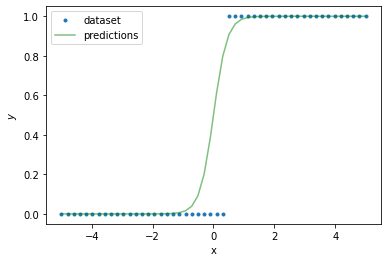

In [9]:
N = 50
x = np.linspace(-5,5, N)
y = (x > 0.5).astype(int)                                  #generate synthetic data
model = LogisticRegression(verbose=True, add_bias=False)
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()

### Multiclass Classifier

In [14]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def softMaxPredict(self, x): #calculating Y_hat with shape Cx1
      a = np.matmul(x, self.W)
      return (np.exp(a)/np.sum(a, axis=1)).reshape(x.shape[0], 1) #if X_n has shape 1xD and w has shape DxC, then Y_hat will have shape 1XC

    def multiCost(self, x, y): #claculating J(w)
      return - np.sum(np.dot(y, np.log(self.softMaxPredict(x))))

    def multiGrad(self, x, y):
      return np.dot(x.transpose(), self.softMaxPredict(x) - y)

    def fit(self, x, y, lr=0.005, niter=100):
      for i in niter:
        self.W = self.W - lr * self.multiGrad(x,y)


## Experiements:

Area Under Curve

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

def AUC(x_train, y_train, x_test, y_test):

  #Using logistic regression
  biasedLogReg =  LogisticRegression()
  y_lr_test_prob = biasedLogReg.fit(x_train, y_train).predict(x_test)
  lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_lr_test_prob)
  lr_roc_auc = roc_auc_score(y_test, y_lr_test_prob)

  #Using KNN
  knn = KNeighborsClassifier() # create a KNN object (OOP)
  knn.fit(x_train, y_train)
  y_knn_test_prob = knn.predict_proba(x_test)[:,1]
  knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, y_knn_test_prob)
  knn_roc_auc = roc_auc_score(y_test, y_knn_test_prob)

  plt.clf()

  plt.plot(lr_fpr, lr_tpr, "r-", lw=2, label="LinReg AUROC = %0.2f"%lr_roc_auc)
  plt.plot(knn_fpr, knn_tpr, "b-", lw=2, label="KNN AUROC = %0.2f"%knn_roc_auc)


  plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC in predicting cancer')
  plt.legend(loc="best")
  plt.savefig("roc_curve.png",bbox_inches='tight', dpi=300)